# I. Autoencoder (Inception Nucleus) with dropout

1. Using dropout only in the encoder helps the model generalize better by regularizing the feature extraction process.
2. Not using dropout in the decoder allows the decoder to focus on accurately reconstructing the input, which is critical for tasks like autoencoding.
3. This combination is a common practice in autoencoders and other neural networks because it balances regularization with accurate output generation.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Conv1D, Conv2D, MaxPooling2D, BatchNormalization, Reshape, UpSampling2D, Conv2DTranspose, Conv1DTranspose, Dropout, Dense, Flatten

gpus = tf.config.list_physical_devices('GPU')
device = '/device:GPU:0' if gpus else '/device:CPU:0'
print(f"Using device: {device}")

Using device: /device:GPU:0


In [2]:
from tensorflow.keras.layers import Lambda, Layer

def InceptionNucleus(input_layer, filters, one_d_dropout_rate=0):
    branches = []
    for f in filters:
        x = Conv1D(filters=32, kernel_size=f, padding='same', activation='relu')(input_layer)
        x = Dropout(one_d_dropout_rate)(x)
        branches.append(x)
    output = tf.keras.layers.concatenate(branches, axis=-1)
    return output

def InceptionNucleusTranspose(input_layer, filters):
    branches = []
    for f in filters:
        x = Conv1DTranspose(filters=32, kernel_size=f, padding='same', activation='relu')(input_layer)
        branches.append(x)
    output = tf.keras.layers.concatenate(branches, axis=-1)
    return output

def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian."""
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Custom layer for KL divergence loss
class KLDivergenceLayer(Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        self.add_loss(kl_loss)
        return inputs


def create_eeg_vae(one_d_dropout_rate=0, two_d_dropout_rate=0,latent_dim=16):
    # Encoder
    inputs = Input(shape=(178, 1))

    # Initial 1D Convolutional Layers with Inception Nucleus
    x = InceptionNucleus(inputs, filters=[4, 8, 12], one_d_dropout_rate=one_d_dropout_rate)

    # Reshape for 2D Convolutions
    x = Reshape((x.shape[1], x.shape[2], 1))(x)  # (178, 96, 1) for example

    # 2D Convolutional Layers
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    encoded = MaxPooling2D((2, 2))(x)  # Compressed representation (encoder output)

    # Flatten for dense layers in latent space
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)

    # Latent mean and variance
    z_mean = Dense(latent_dim, name='z_mean')(x)
    z_log_var = Dense(latent_dim, name='z_log_var')(x)

    z_mean, z_log_var = KLDivergenceLayer()([z_mean, z_log_var])

    # Sampling layer
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

    # Decoder: start from the sampled latent space
    x = Dense(128, activation='relu')(z)
    x = Dense((178 // 2) * (96) * 1, activation='relu')(x)
    x = Reshape((178 // 2, 96, 1))(x)

    # Decoder: reverse the encoder
    x = UpSampling2D((2, 2))(encoded)  # Reverse the max-pooling
    x = Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(two_d_dropout_rate)(x)

    # Reshape back to 1D format for InceptionNucleusTranspose
    x = Reshape((178, 96 * 64))(x)  # Flatten the feature maps
    x = Conv1D(96, kernel_size=1, activation='relu')(x)  # Reduce feature maps from 96 * 64 to 96

    # InceptionNucleusTranspose: reverse the multi-scale convolutions
    x = InceptionNucleusTranspose(x, filters=[4, 8, 12])

    # Final reconstruction layer to original input dimensions
    outputs = Conv1D(1, kernel_size=1, padding='same', activation='sigmoid')(x)

    # Variational Autoencoder Model
    vae = Model(inputs, outputs)

    vae.compile(optimizer='adam', loss='mse')

    # Create a separate encoder model (without sampling)
    encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")

    return vae, encoder

autoencoder, encoder = create_eeg_vae()
print ("Autoencoder:")
autoencoder.summary()
print ("Encoder:")
encoder.summary()

2024-10-30 14:08:11.215691: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-10-30 14:08:11.215717: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-10-30 14:08:11.215723: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-10-30 14:08:11.215755: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-30 14:08:11.215765: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Autoencoder:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 178, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 178, 32)   │        160 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 178, 32)   │        288 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 178, 32)   │        416 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 178, 32)   │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 178, 32)   │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 178, 32)   │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 178, 96)   │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0],  │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 178, 96,   │          0 │ concatenate[0][0] │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 178, 96,   │        640 │ reshape[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 178, 96,   │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 89, 48,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 178, 96,   │          0 │ max_pooling2d[0]… │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 178, 96,   │     36,928 │ up_sampling2d[0]… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 178, 96,   │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 178, 96,   │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 178, 6144) │          0 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 178, 96)   │    589,920 │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_transpose    │ (None, 178, 32)   │     12,320 │ conv1d_3[0][0]    │
│ (Conv1DTranspose)   │                   │            │                 

 Total params: 702,785 (2.68 MB)

 Trainable params: 702,529 (2.68 MB)

 Non-trainable params: 256 (1.00 KB)

Encoder:


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 178, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 178, 32)   │        160 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 178, 32)   │        288 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 178, 32)   │        416 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 178, 32)   │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 178, 32)   │          0 │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 178, 32)   │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 178, 96)   │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0],  │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 178, 96,   │          0 │ concatenate[0][0] │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 178, 96,   │        640 │ reshape[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 178, 96,   │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1093632)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │ 139,985,0… │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 16)        │      2,064 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 16)        │      2,064 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ kl_divergence_layer │ [(None, 16),      │          0 │ z_mean[0][0],     │
│ (KLDivergenceLayer) │ (None, 16)]       │            │ z_log_var[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 16)        │          0 │ kl_divergence_la… │
│                     │                   │            │ kl_divergence_la… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 139,990,912 (534.02 MB)

 Trainable params: 139,990,784 (534.02 MB)

 Non-trainable params: 128 (512.00 B)

In [3]:
# Load data

train_data = pd.read_csv('./dataset/hard_test/train.csv', index_col=0)
test_data = pd.read_csv('./dataset/hard_test/test.csv', index_col=0)

X_train = train_data.iloc[:, :-1].values  # X1-X178
X_test = test_data.iloc[:, :-1].values    # X1-X178

# Normalize the data
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the data for the model
X_train_scaled = X_train_scaled.reshape(-1, 178, 1)
X_test_scaled = X_test_scaled.reshape(-1, 178, 1)

In [4]:
def train(device, X_train_scaled, X_test_scaled, epochs=3, batch_size=32, one_d_dropout_rate=0, two_d_dropout_rate=0):
    # Check if GPU is available
    with tf.device(device): 
        # Define and compile the VAE
        autoencoder, encoder = create_eeg_vae(one_d_dropout_rate=one_d_dropout_rate, two_d_dropout_rate=two_d_dropout_rate)
        
        # Early stopping callback for improved training stability
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        # Train the VAE
        history = autoencoder.fit(
            X_train_scaled, X_train_scaled,  # Training the VAE to reconstruct the input
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=1
        )
    
    with tf.device(device): 
        # Evaluate on test data
        test_loss = autoencoder.evaluate(X_test_scaled, X_test_scaled)
        print("Test loss (reconstruction error):", test_loss)

    # Plot the training and validation loss over epochs
    plt.figure(figsize=(12, 6))  # Create a new figure
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()  # Make sure subplots are nicely spaced
    plt.show()  # Show plot here to avoid overlap with other plots
    
    return autoencoder, encoder


def visualize(X_test, X_test_scaled, autoencoder, scaler):
    # Check if the input is a single sample or the entire dataset
    if len(X_test_scaled.shape) == 2:  # Shape (178, 1), single sample
        original_sample_scaled = X_test_scaled
    else:  # Assume the input is the full dataset (e.g., 1112, 178, 1), take the first sample
        original_sample_scaled = X_test_scaled[0]  # Shape (178, 1)

    # Reshape it for prediction (add batch dimension)
    original_sample_scaled = np.expand_dims(original_sample_scaled, axis=0)  # Shape (1, 178, 1)

    # Reconstruct test data using the autoencoder
    reconstructed_scaled = autoencoder.predict(original_sample_scaled, verbose=0).reshape(178, 1)

    # Reshape reconstructed_scaled to match the shape that the scaler expects (1, 178)
    reconstructed_scaled = reconstructed_scaled.reshape(1, 178)
    reconstructed_unscaled = scaler.inverse_transform(reconstructed_scaled)

    # Flatten original_sample_scaled for plotting (remove batch and feature dims)
    X_test_flat = X_test.flatten()

    # Flatten reconstructed_unscaled for plotting
    reconstructed_unscaled_flat = reconstructed_unscaled.flatten()

    # Plot original and reconstructed test samples
    plt.figure(figsize=(12, 6))  # Create a new figure for this plot
    plt.plot(X_test_flat, label='Original')  # Flatten for plotting
    plt.plot(reconstructed_unscaled_flat, label='Reconstructed', color='orange')  # Flatten for plotting
    plt.title('Original vs Reconstructed Test Sample')
    plt.legend()

    plt.tight_layout()  # Ensure subplots are well spaced
    plt.show()

In [5]:
def train_and_test_autoencoder(epochs=3, batch_size=32, one_d_dropout_rate=0, two_d_dropout_rate=0):
    # 1. Load the data
    train_data = pd.read_csv('./dataset/hard_test/train.csv', index_col=0)
    test_data = pd.read_csv('./dataset/hard_test/test.csv', index_col=0)
    
    X_train = train_data.iloc[:, :-1].values  # X1-X178
    X_test = test_data.iloc[:, :-1].values    # X1-X178
    
    # 2. Normalize the data
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Reshape the data
    X_train_scaled = X_train_scaled.reshape(-1, 178, 1)
    X_test_scaled = X_test_scaled.reshape(-1, 178, 1)
    
    # Check if GPU is available
    gpus = tf.config.list_physical_devices('GPU')
    device = '/device:GPU:0' if gpus else '/device:CPU:0'
    print(f"Using device: {device}")
    
    with tf.device(device): 
        # 3. Define and compile the autoencoder
        autoencoder, encoder = create_eeg_vae(one_d_dropout_rate=one_d_dropout_rate, two_d_dropout_rate=two_d_dropout_rate)
        # autoencoder.compile(optimizer=Adam(learning_rate=0.0001), loss='mse')
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        # 4. Train the autoencoder
        history = autoencoder.fit(
            X_train_scaled, X_train_scaled,  # Training the autoencoder to reconstruct the input
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            callbacks=[early_stopping],
            verbose=1
        )
    
    with tf.device(device): 
        # 5. Evaluate on test data
        test_loss = autoencoder.evaluate(X_test_scaled, X_test_scaled)
        print("Test loss (reconstruction error):", test_loss)
        
        # 6. Use the autoencoder to make predictions (reconstruct the test data)
        X_test_reconstructed = autoencoder.predict(X_test_scaled)
    
    # Bring it back to the original scale
    X_test_reconstructed_unscaled = scaler.inverse_transform(X_test_reconstructed.reshape(-1, 178))
    
    # 7. Plot the training and validation loss over epochs
    plt.figure(figsize=(12, 6))
    
    # Plot training & validation loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # 8. Plot original and reconstructed test samples
    plt.subplot(1, 2, 2)
    plt.plot(X_test[0], label='Original')
    plt.plot(X_test_reconstructed_unscaled[0], label='Reconstructed')
    plt.title('Original vs Reconstructed Test Sample')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    return autoencoder, encoder

## Baseline: No dropout

In [ ]:
autoencoder, _ = train_and_test_autoencoder(epochs=10, batch_size=32, one_d_dropout_rate=0, two_d_dropout_rate=0)

Using device: /device:GPU:0
Epoch 1/10


2024-10-30 14:10:01.163684: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


  3/260 ━━━━━━━━━━━━━━━━━━━━ 8:34:40 120s/step - loss: 0.1265 

## Experiment 1: Dropout after 1d Conv

### Dropout=0.25

Using device: /device:GPU:0
Epoch 1/10
260/260 [==============================] - 24s 79ms/step - loss: 0.0030 - val_loss: 0.0936
Epoch 2/10
260/260 [==============================] - 20s 78ms/step - loss: 5.1031e-04 - val_loss: 0.0693
Epoch 3/10
260/260 [==============================] - 20s 78ms/step - loss: 3.6341e-04 - val_loss: 0.0234
Epoch 4/10
260/260 [==============================] - 20s 78ms/step - loss: 2.7999e-04 - val_loss: 0.0181
Epoch 5/10
260/260 [==============================] - 20s 77ms/step - loss: 2.3133e-04 - val_loss: 0.0179
Epoch 6/10
260/260 [==============================] - 20s 77ms/step - loss: 2.0863e-04 - val_loss: 0.0180
Epoch 7/10
260/260 [==============================] - 20s 77ms/step - loss: 1.7981e-04 - val_loss: 0.0190
Epoch 8/10
260/260 [==============================] - 20s 77ms/step - loss: 1.6169e-04 - val_loss: 0.0187
Epoch 9/10
260/260 [==============================] - 20s 77ms/step - loss: 1.4527e-04 - val_loss: 0.0181
Epoch 10/10
35/35 [===

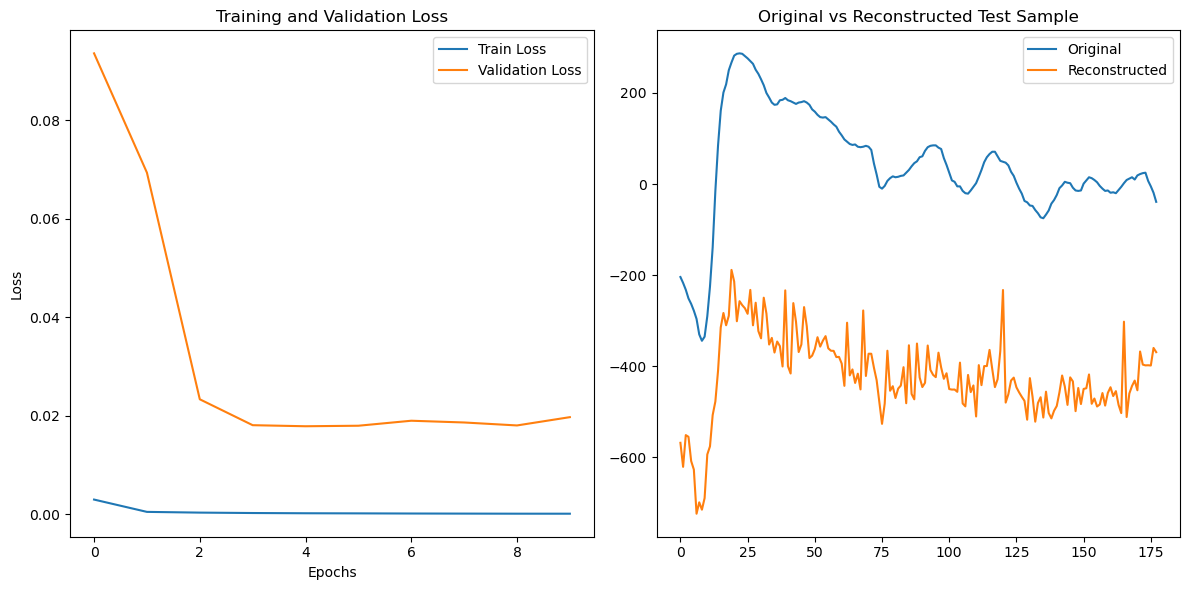

In [12]:
autoencoder, _ = train_and_test_autoencoder(epochs=10, batch_size=32, one_d_dropout_rate=0.25, two_d_dropout_rate=0)

### Dropout=0.5

Using device: /device:GPU:0
Epoch 1/10
 60/260 [=====>........................] - ETA: 14s - loss: 0.0075

260/260 [==============================] - 23s 78ms/step - loss: 0.0026 - val_loss: 0.0989
Epoch 2/10
260/260 [==============================] - 20s 77ms/step - loss: 5.3652e-04 - val_loss: 0.1252
Epoch 3/10
260/260 [==============================] - 20s 78ms/step - loss: 3.8672e-04 - val_loss: 0.1106
Epoch 4/10
260/260 [==============================] - 20s 77ms/step - loss: 3.2513e-04 - val_loss: 0.0976
Epoch 5/10
260/260 [==============================] - 20s 78ms/step - loss: 2.8181e-04 - val_loss: 0.0961
Epoch 6/10
260/260 [==============================] - 20s 78ms/step - loss: 2.5320e-04 - val_loss: 0.0924
Epoch 7/10
260/260 [==============================] - 20s 78ms/step - loss: 2.3718e-04 - val_loss: 0.0848
Epoch 8/10
260/260 [==============================] - 20s 77ms/step - loss: 2.1861e-04 - val_loss: 0.0839
Epoch 9/10
260/260 [==============================] - 20s 77ms/step - loss: 2.0027e-04 - val_loss: 0.0830
Epoch 10/10
35/35 [==============================] - 1s 22ms/

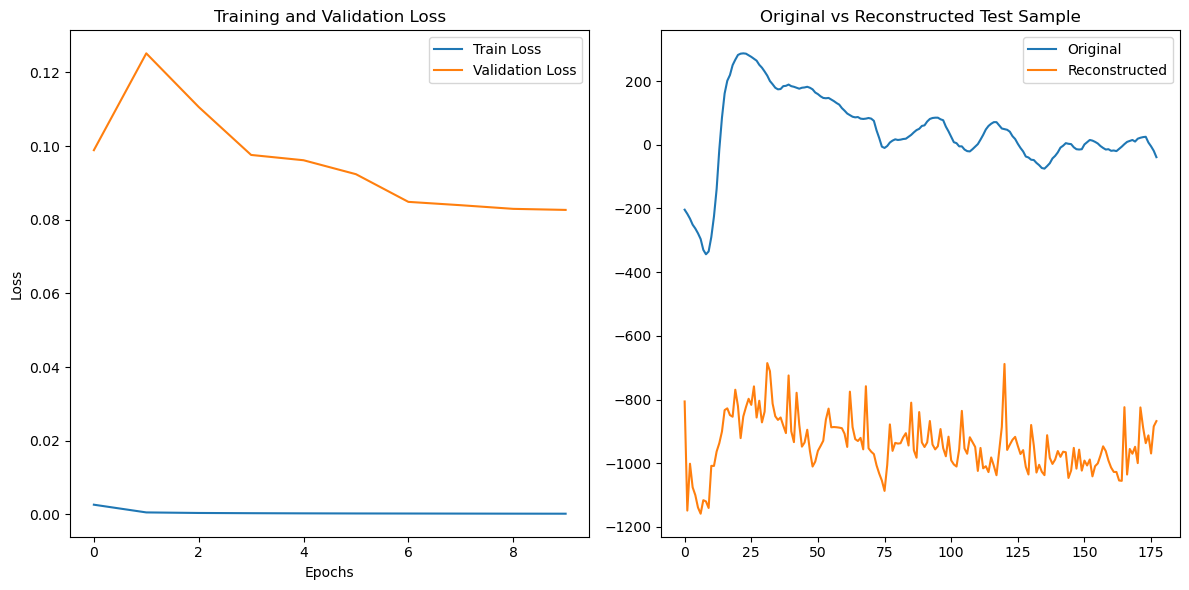

In [13]:
autoencoder, _ = train_and_test_autoencoder(epochs=10, batch_size=32, one_d_dropout_rate=0.5, two_d_dropout_rate=0)

## Experiment 2: Dropout after 2d Conv

### Dropout=0.25

Using device: /device:GPU:0
Epoch 1/10


2024-10-27 06:38:49.995695: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/dropout_19/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


260/260 [==============================] - 29s 103ms/step - loss: 0.0047 - val_loss: 0.0174
Epoch 2/10
260/260 [==============================] - 26s 102ms/step - loss: 6.5982e-04 - val_loss: 0.0130
Epoch 3/10
260/260 [==============================] - 26s 102ms/step - loss: 4.2042e-04 - val_loss: 6.3931e-04
Epoch 4/10
260/260 [==============================] - 26s 102ms/step - loss: 3.1411e-04 - val_loss: 1.0231e-04
Epoch 5/10
260/260 [==============================] - 27s 102ms/step - loss: 2.5155e-04 - val_loss: 9.7289e-05
Epoch 6/10
260/260 [==============================] - 27s 102ms/step - loss: 2.1015e-04 - val_loss: 8.7124e-05
Epoch 7/10
260/260 [==============================] - 27s 102ms/step - loss: 1.8543e-04 - val_loss: 7.2032e-05
Epoch 8/10
260/260 [==============================] - 27s 102ms/step - loss: 1.6178e-04 - val_loss: 7.2121e-05
Epoch 9/10
260/260 [==============================] - 27s 102ms/step - loss: 1.5094e-04 - val_loss: 8.4792e-05
Epoch 10/10
35/35 [=====

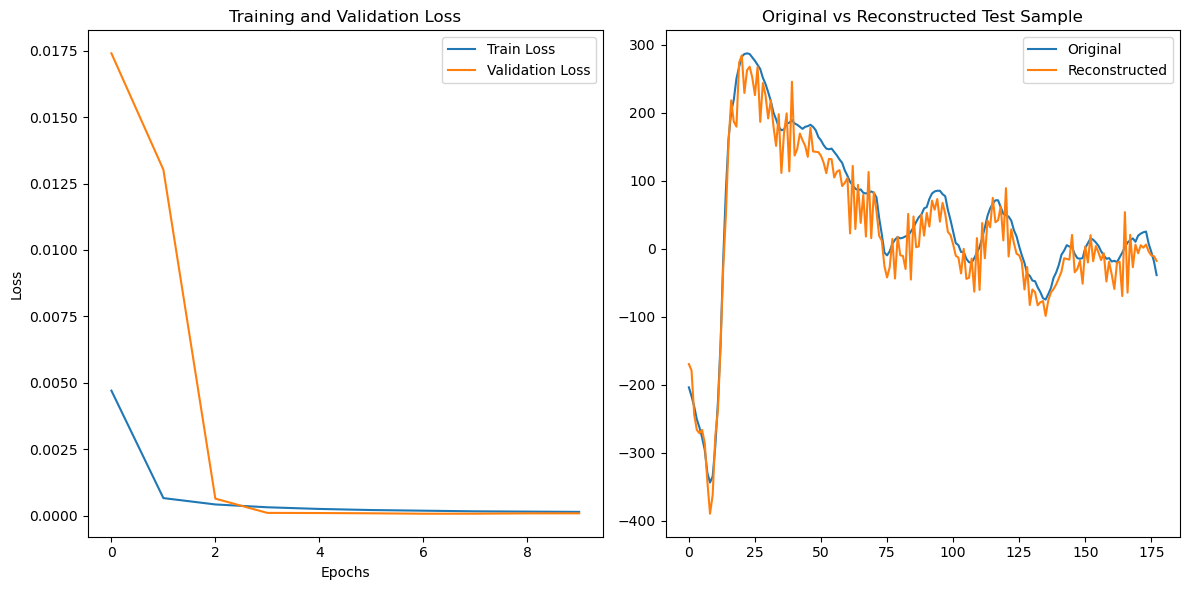

In [14]:
autoencoder, _ = train_and_test_autoencoder(epochs=10, batch_size=32, one_d_dropout_rate=0, two_d_dropout_rate=0.25)

### Dropout=0.5

Using device: /device:GPU:0
Epoch 1/10


2024-10-27 06:43:20.478318: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_5/dropout_23/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


260/260 [==============================] - 29s 103ms/step - loss: 0.0044 - val_loss: 0.0655
Epoch 2/10
260/260 [==============================] - 26s 102ms/step - loss: 6.3263e-04 - val_loss: 0.0227
Epoch 3/10
260/260 [==============================] - 27s 102ms/step - loss: 3.8051e-04 - val_loss: 9.6734e-04
Epoch 4/10
260/260 [==============================] - 27s 102ms/step - loss: 2.8078e-04 - val_loss: 1.3492e-04
Epoch 5/10
260/260 [==============================] - 27s 102ms/step - loss: 2.3445e-04 - val_loss: 1.1309e-04
Epoch 6/10
260/260 [==============================] - 27s 102ms/step - loss: 2.1417e-04 - val_loss: 2.0502e-04
Epoch 7/10
260/260 [==============================] - 27s 102ms/step - loss: 1.9667e-04 - val_loss: 1.0243e-04
Epoch 8/10
260/260 [==============================] - 27s 102ms/step - loss: 1.7434e-04 - val_loss: 1.0561e-04
Epoch 9/10
260/260 [==============================] - 27s 103ms/step - loss: 1.6224e-04 - val_loss: 9.4870e-05
Epoch 10/10
35/35 [=====

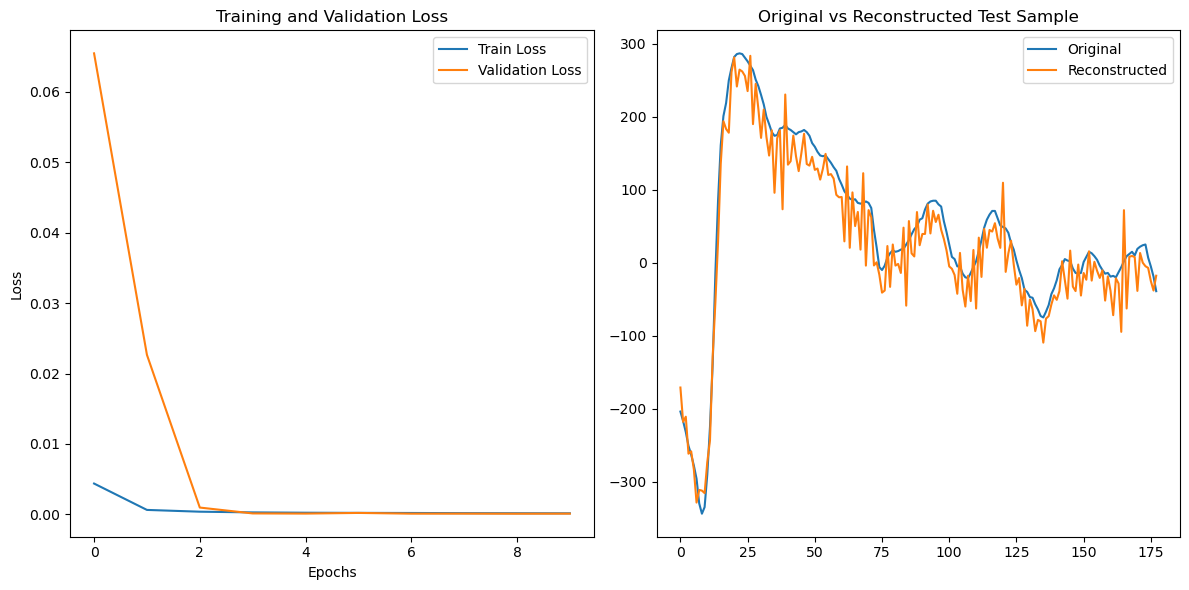

In [15]:
autoencoder, _ = train_and_test_autoencoder(epochs=10, batch_size=32, one_d_dropout_rate=0, two_d_dropout_rate=0.5)

## Best: No dropout

Epoch 1/10


2024-10-28 02:19:44.638419: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-10-28 02:19:46.532698: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7ff0c83bcef0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-10-28 02:19:46.532727: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2024-10-28 02:19:46.538631: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-28 02:19:46.634565: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


260/260 [==============================] - 29s 86ms/step - loss: 8.2190e-04 - val_loss: 0.0572
Epoch 2/10
260/260 [==============================] - 20s 76ms/step - loss: 9.4465e-05 - val_loss: 0.0152
Epoch 3/10
260/260 [==============================] - 20s 77ms/step - loss: 7.4414e-05 - val_loss: 0.0011
Epoch 4/10
260/260 [==============================] - 20s 77ms/step - loss: 6.3733e-05 - val_loss: 3.3188e-05
Epoch 5/10
260/260 [==============================] - 20s 77ms/step - loss: 5.4140e-05 - val_loss: 4.6204e-05
Epoch 6/10
260/260 [==============================] - 20s 77ms/step - loss: 5.1477e-05 - val_loss: 4.2114e-05
Epoch 7/10
260/260 [==============================] - 20s 77ms/step - loss: 5.5644e-05 - val_loss: 3.6616e-05
Epoch 8/10
260/260 [==============================] - 20s 77ms/step - loss: 4.6819e-05 - val_loss: 2.5424e-05
Epoch 9/10
260/260 [==============================] - 20s 78ms/step - loss: 4.3568e-05 - val_loss: 3.1737e-05
Epoch 10/10
35/35 [==============

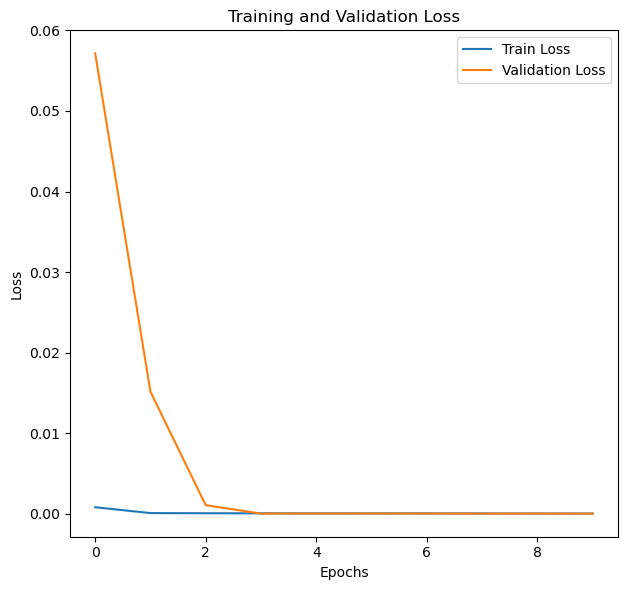

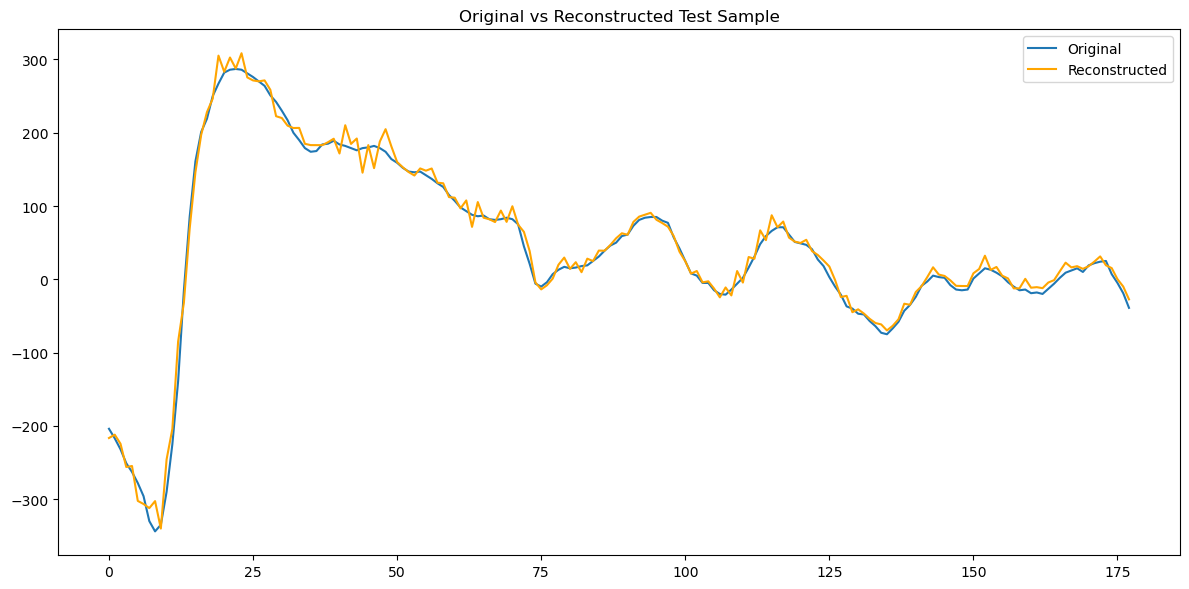

In [7]:
autoencoder, encoder = train(device, X_train_scaled, X_test_scaled, epochs=10, batch_size=32, one_d_dropout_rate=0, two_d_dropout_rate=0)
visualize(X_test[0], X_test_scaled[0], autoencoder, scaler)

In [8]:
# # Save the model
# from tensorflow.keras.models import load_model

# # Saving the autoencoder and encoder models
# autoencoder.save('autoencoder_model.h5')  # Save the autoencoder
# encoder.save('encoder_model.h5')  # Optionally save the encoder if you want to use it separately

# # Loading the saved models
# autoencoder = load_model('autoencoder_model.h5')
# encoder = load_model('encoder_model.h5')  # Optional if you need the encoder

/opt/conda/envs/capstone/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# II. Test result: before and after autoencoder augmentation

In [9]:
def evaluate_classification_metrics(y_true, y_pred, y_pred_prob):
    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Calculate precision
    precision = precision_score(y_true, y_pred)
    
    # Calculate recall
    recall = recall_score(y_true, y_pred)
    
    # Calculate F1 score
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    if len(set(y_true)) > 1:
        # Check if ROC-AUC can be calculated (i.e., both classes are present)
        roc_auc = roc_auc_score(y_true, y_pred_prob)
        # Calculate Cohen's Kappa
        kappa = cohen_kappa_score(y_true, y_pred)
    else:
        roc_auc = None  # Not computable, only one class in y_true
        kappa = None
    
    # Calculate metrics for seizure class (y_label=1)
    precision_seizure = precision_score(y_true, y_pred, pos_label=1)
    recall_seizure = recall_score(y_true, y_pred, pos_label=1)
    f1_seizure = f1_score(y_true, y_pred, pos_label=1)
    
    # Calculate metrics for non-seizure class (y_label=0)
    precision_non_seizure = precision_score(y_true, y_pred, pos_label=0)
    recall_non_seizure = recall_score(y_true, y_pred, pos_label=0)
    f1_non_seizure = f1_score(y_true, y_pred, pos_label=0)
    
    print(f'\nSeizure (y=1):')
    print(f'  Precision: {precision_seizure * 100:.2f} %')
    print(f'  Recall: {recall_seizure * 100:.2f} %')
    print(f'  F1 Score: {f1_seizure * 100:.2f} %')
    
    print(f'\nNon-Seizure (y=0):')
    print(f'  Precision: {precision_non_seizure * 100:.2f} %')
    print(f'  Recall: {recall_non_seizure * 100:.2f} %')
    print(f'  F1 Score: {f1_non_seizure * 100:.2f} %')
    
    # Print metrics
    print(f'\nOverall:')
    print(f'  Accuracy: {accuracy * 100:.2f} %')
    print(f'  Precision: {precision * 100:.2f} %')
    print(f'  Recall: {recall * 100:.2f} %')
    print(f'  F1 Score: {f1 * 100:.2f} %')
    if roc_auc is not None:
        print(f'  ROC-AUC: {roc_auc * 100:.2f} %')
    if kappa is not None:
        print(f'  Cohen\'s Kappa: {kappa * 100:.2f} %')

In [10]:
def InceptionNucleus(input_layer, filters):
    branches = []
    for f in filters:
        x = Conv1D(filters=32, kernel_size=f, padding='same', activation='relu')(input_layer)
        branches.append(x)
    output = tf.keras.layers.concatenate(branches, axis=-1)
    return output

def create_eeg_cnn(input_shape=(178, 1), num_classes=2):
    inputs = Input(shape=input_shape)

    # Initial 1D Convolutional Layers with Inception Nucleus
    x = InceptionNucleus(inputs, filters=[4, 8, 12])

    # Reshape for 2D Convolutions
    x = Reshape((x.shape[1], x.shape[2], 1))(x) # (178, 96, 1) for example

    # 2D Convolutional Layers
    x = Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Flatten after 2D Convolutions
    x = Flatten()(x)

    # Output Layer
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [12]:
y_train = train_data['y']
y_test = test_data['y']
y_train = y_train.values if isinstance(y_train, pd.Series) else y_train
y_test = y_test.values if isinstance(y_test, pd.Series) else y_test

## Before augmentation

##  Inception Nucleus

In [39]:
def train_and_test_classification(X_train, y_train, X_test, y_test):
    # Create the model
    model = create_eeg_cnn(input_shape=(178, 1), num_classes=2)
    
    # Define early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train the model and store the training history
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),  # For evaluation during training
        epochs=30,                         # Number of epochs
        batch_size=32,                     # Batch size (adjust based on memory)
        callbacks=[early_stopping],        # Early stopping
        verbose=1                          # Print progress
    )
    
    # After training, evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    
    # Predict class probabilities for the test set
    y_pred_prob = model.predict(X_test)
    
    # Convert probabilities to binary class labels (assuming threshold 0.5)
    y_pred = (y_pred_prob[:, 1] > 0.5).astype(int)
    
    # Evaluate classification metrics using the provided function
    evaluate_classification_metrics(y_test, y_pred, y_pred_prob[:, 1])
    
    print(f'Test Loss: {test_loss}')
    print(f'Test Accuracy: {test_accuracy}')
    
    # Plot training & validation loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


Epoch 1/30
325/325 [==============================] - 7s 19ms/step - loss: 5.0318 - accuracy: 0.9643 - val_loss: 109.5353 - val_accuracy: 0.5800
Epoch 2/30
325/325 [==============================] - 6s 18ms/step - loss: 5.2437 - accuracy: 0.9676 - val_loss: 61.1986 - val_accuracy: 0.7302
Epoch 3/30
325/325 [==============================] - 6s 18ms/step - loss: 2.1813 - accuracy: 0.9811 - val_loss: 45.0266 - val_accuracy: 0.7626
Epoch 4/30
325/325 [==============================] - 6s 18ms/step - loss: 1.0903 - accuracy: 0.9877 - val_loss: 26.6705 - val_accuracy: 0.7797
Epoch 5/30
325/325 [==============================] - 6s 18ms/step - loss: 1.1009 - accuracy: 0.9874 - val_loss: 40.0433 - val_accuracy: 0.7860
Epoch 6/30
325/325 [==============================] - 6s 18ms/step - loss: 0.5571 - accuracy: 0.9928 - val_loss: 19.5607 - val_accuracy: 0.8264
Epoch 7/30
325/325 [==============================] - 6s 18ms/step - loss: 0.6126 - accuracy: 0.9928 - val_loss: 31.1336 - val_accuracy

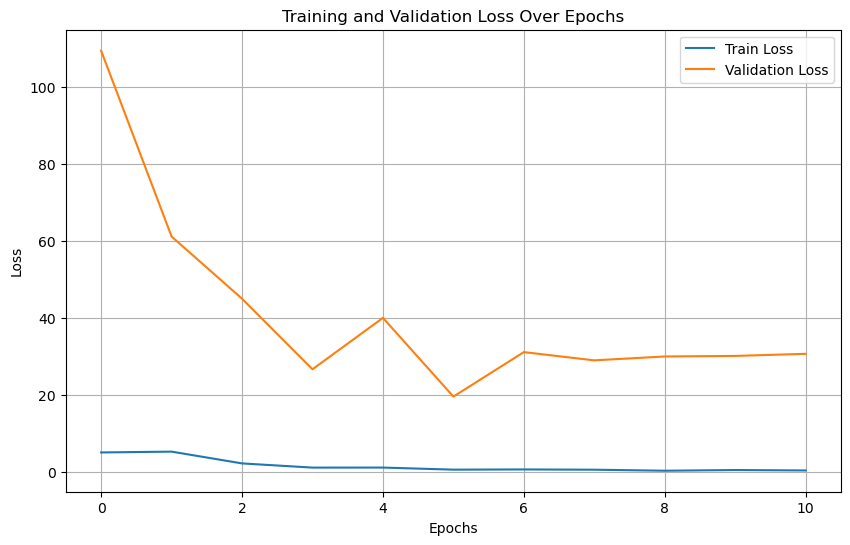

In [40]:
train_and_test_classification(X_train, y_train, X_test, y_test)

## After Augmentation

### Augment dataset
Method 1: Feed reconstructed signal back to Autoencoder n times, to create n different augmented version

Method 2: Add Noise to the Latent Space: Pass the input signal through the encoder to obtain the latent representation, then add noise to the latent representation to generate different versions of the signal.
Add Noise to the Input Signal:

Method 3: Add noise to the input signal before passing it through the autoencoder. This can produce slightly different outputs each time.

#### Method 1: Feed reconstructed signal back to Autoencoder n times, to create n different augmented version.

Augmenting signal for sample 0
Augmenting signal for sample 1
Sample 0 has (5, 1, 178, 1) augmented signals.
Sample 1 has (5, 1, 178, 1) augmented signals.


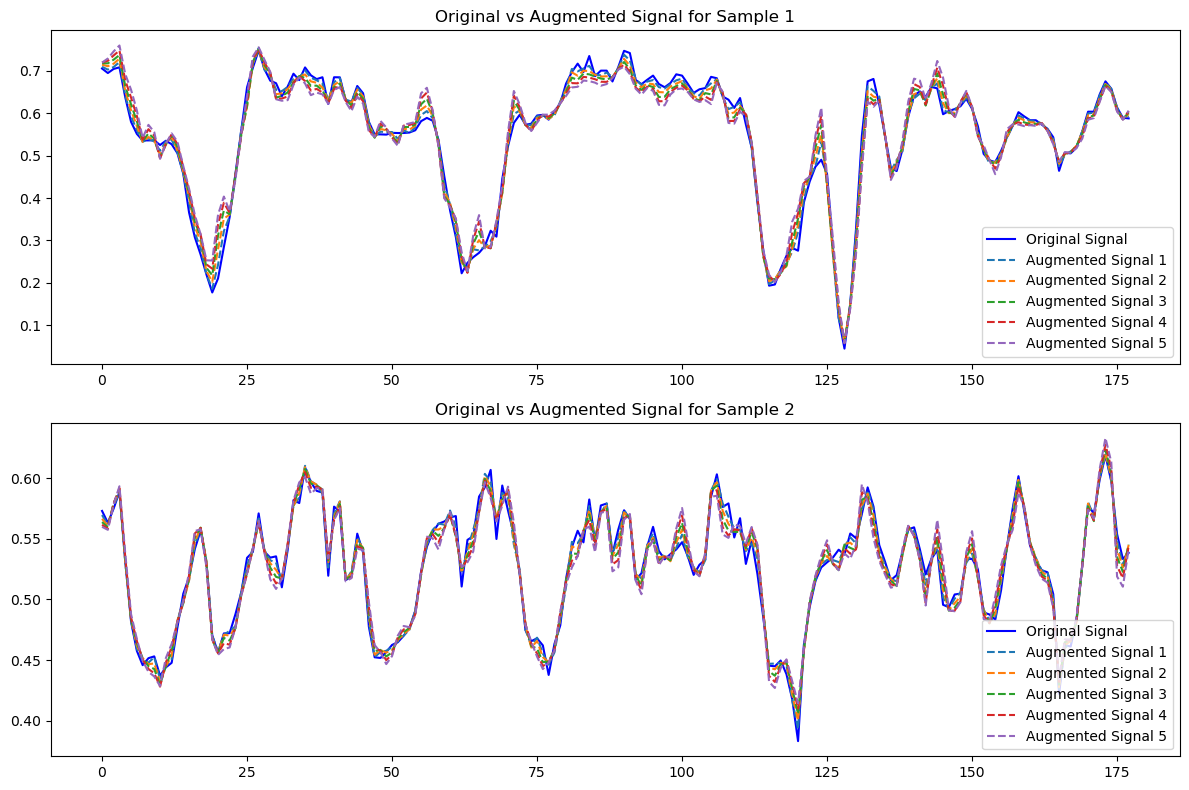

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Function to plot original vs augmented signals
def plot_original_vs_augmented(X_original, X_augmented, n_augmentations):
    plt.figure(figsize=(12, 8))
    
    for i in range(2):  # Plot for the first 2 samples
        plt.subplot(2, 1, i + 1)
        plt.plot(X_original[i].squeeze(), label='Original Signal', color='blue')  # Plot original signal
        
        # Plot each of the n_augmentations for the current original signal
        for aug_idx in range(n_augmentations):
            plt.plot(X_augmented[i][aug_idx].squeeze(), label=f'Augmented Signal {aug_idx+1}', linestyle='--')
        
        plt.title(f'Original vs Augmented Signal for Sample {i+1}')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Function to manually augment a signal n times
def augment_signal_n_times(original_signal_scaled, autoencoder, n=5, noise_level=0.1):
    augmented_signals = []
    current_signal_scaled = original_signal_scaled

    for _ in range(n):
        # Pass the current signal through the autoencoder to get a reconstruction
        reconstructed_scaled = autoencoder.predict(current_signal_scaled, verbose=0)
        
        # Add noise to the reconstructed signal to create variation in augmentations
        # reconstructed_scaled = reconstructed_scaled + np.random.normal(0, noise_level, reconstructed_scaled.shape)
        
        # Append the augmented signal
        augmented_signals.append(reconstructed_scaled)
        
        # Feed back the perturbed signal for the next iteration
        current_signal_scaled = reconstructed_scaled
    
    # Return the list of augmented signals
    return np.array(augmented_signals)

# Example usage
n_augmentations = 5  # Number of augmentations to generate
first_two_augmented_signals = [[] for _ in range(2)]  # Placeholder for augmented signals for the first two samples

# Augment the first 2 original signals
for sample_idx in range(2):  # For each of the first two samples
    print(f"Augmenting signal for sample {sample_idx}")  # Debugging print
    # Augment each signal 5 times
    augmented_signals = augment_signal_n_times(X_train_scaled[sample_idx:sample_idx+1], autoencoder, n=n_augmentations)
    first_two_augmented_signals[sample_idx] = augmented_signals

# Convert lists into arrays for easier handling
first_two_augmented_signals = [np.array(first_two_augmented_signals[i]) for i in range(2)]

# Check the structure of augmented signals
for idx, augmented_signals in enumerate(first_two_augmented_signals):
    print(f"Sample {idx} has {augmented_signals.shape} augmented signals.")  # Debugging: check structure

# Plot the original and augmented signals for the first two samples
plot_original_vs_augmented(X_train_scaled[:2], first_two_augmented_signals, n_augmentations)


In [30]:
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Custom data generator to yield batches of augmented signals and labels
def data_generator(X_train_scaled, y_train, autoencoder, n_augmentations=5, batch_size=32):
    num_samples = X_train_scaled.shape[0]

    while True:  # Infinite loop, since fit_generator will stop automatically based on the number of steps
        for i in range(0, num_samples, batch_size):
            # Get the batch of original signals and labels
            batch_X = X_train_scaled[i:i + batch_size]
            batch_y = y_train[i:i + batch_size]

            # Initialize lists to hold the augmented signals and labels for the current batch
            augmented_batch_X = []
            augmented_batch_y = []

            # Add the original signals and labels to the batch
            augmented_batch_X.append(batch_X)
            augmented_batch_y.append(batch_y)

            # Generate n_augmentations for each signal in the batch
            for _ in range(n_augmentations):
                # Predict the batch using the autoencoder to create augmented signals
                reconstructed_batch = autoencoder.predict(batch_X, verbose=0)
                # reconstructed_batch = reconstructed_batch + np.random.normal(0, 0.1, reconstructed_batch.shape)
                augmented_batch_X.append(reconstructed_batch)
                augmented_batch_y.append(batch_y)

            # Concatenate all the augmentations into one array for the batch
            augmented_batch_X = np.vstack(augmented_batch_X)  # Shape: (batch_size * n_augmentations, ...)
            augmented_batch_y = np.hstack(augmented_batch_y)  # Shape: (batch_size * n_augmentations,)

            # Yield the augmented signals and corresponding labels
            yield augmented_batch_X, augmented_batch_y

# Modify train_and_test_classification to accept a generator
def train_and_test_classification(X_train_scaled, y_train, X_test, y_test, autoencoder, n_augmentations=5, batch_size=32):
    # Create the model
    model = create_eeg_cnn(input_shape=(178, 1), num_classes=2)
    
    # Specify the optimizer with a custom learning rate
    optimizer = Adam(learning_rate=0.00001)  # You can adjust the learning rate here
    
    # Compile the model with the optimizer and loss function
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Define early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Calculate the number of steps per epoch (needed for the generator)
    steps_per_epoch = (len(X_train_scaled) * (1 + n_augmentations)) // batch_size

    # Train the model using the generator
    history = model.fit(
        data_generator(X_train_scaled, y_train, autoencoder, n_augmentations, batch_size),  # The generator for training
        validation_data=(X_test, y_test),   # For evaluation during training
        epochs=30,                          # Number of epochs
        steps_per_epoch=steps_per_epoch,    # Number of steps per epoch
        callbacks=[early_stopping],         # Early stopping
        verbose=1                           # Print progress
    )
    
    # After training, evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    
    # Predict class probabilities for the test set
    y_pred_prob = model.predict(X_test)
    
    # Convert probabilities to binary class labels (assuming threshold 0.5)
    y_pred = (y_pred_prob[:, 1] > 0.5).astype(int)
    
    # Evaluate classification metrics using the provided function
    evaluate_classification_metrics(y_test, y_pred, y_pred_prob[:, 1])
    
    print(f'Test Loss: {test_loss}')
    print(f'Test Accuracy: {test_accuracy}')
    
    # Plot training & validation loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch 1/30
324/324 [==============================] - 115s 350ms/step - loss: 0.8959 - accuracy: 0.9066 - val_loss: 2053.7727 - val_accuracy: 0.2446
Epoch 2/30
324/324 [==============================] - 113s 350ms/step - loss: 0.0970 - accuracy: 0.9641 - val_loss: 8742.8945 - val_accuracy: 0.2446
Epoch 3/30
324/324 [==============================] - 114s 352ms/step - loss: 0.0871 - accuracy: 0.9677 - val_loss: 13709.4746 - val_accuracy: 0.2446
Epoch 4/30
324/324 [==============================] - 113s 351ms/step - loss: 0.0773 - accuracy: 0.9704 - val_loss: 13232.7559 - val_accuracy: 0.2446
Epoch 5/30
324/324 [==============================] - 113s 350ms/step - loss: 0.0706 - accuracy: 0.9721 - val_loss: 12766.1719 - val_accuracy: 0.2446
Epoch 6/30
35/35 [==============================] - 0s 5ms/step

Seizure (y=1):
  Precision: 24.46 %
  Recall: 100.00 %
  F1 Score: 39.31 %

Non-Seizure (y=0):
  Precision: 0.00 %
  Recall: 0.00 %
  F1 Score: 0.00 %

Overall:
  Accuracy: 24.46 %
  Prec

/opt/conda/envs/capstone/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


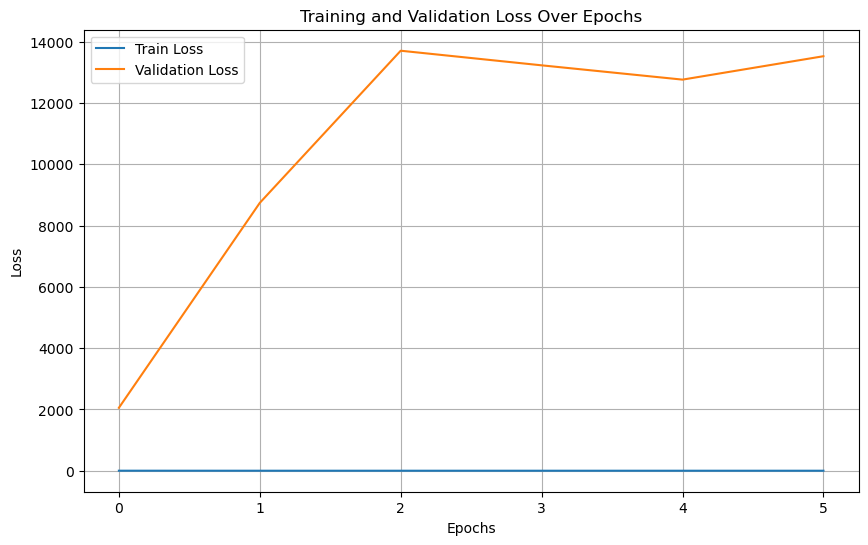

In [15]:
# Example usage
train_and_test_classification(X_train_scaled, y_train, X_test, y_test, autoencoder, n_augmentations=5, batch_size=32)


In [ ]:
# Example usage
train_and_test_classification(X_train_scaled, y_train, X_test, y_test, autoencoder, n_augmentations=5, batch_size=32)

#### Method 2: Add Noise to the Latent Space: Pass the input signal through the encoder to obtain the latent representation, then add noise to the latent representation to generate different versions of the signal.

In [ ]:
# Pass the signal through the encoder to get the latent representation
latent_rep = autoencoder.predict(X_train)

# Add noise to the latent space to create multiple variations
def generate_augmented_signals(latent_rep, num_augmentations=5, noise_level=0.1):
    augmented_signals = []
    for _ in range(num_augmentations):
        # Add random noise to the latent representation
        perturbed_latent = latent_rep + np.random.normal(0, noise_level, latent_rep.shape)
        # Decode the perturbed latent space back to a signal
        augmented_signal = autoencoder.predict(perturbed_latent)  # Decode using the autoencoder
        augmented_signals.append(augmented_signal)
    return np.vstack(augmented_signals)

augmented_signals = generate_augmented_signals(latent_rep, num_augmentations=5)
y_train_augmented = np.tile(y_train, 5)  # Repeat the original labels 5 times
X_train_augmented = np.vstack([X_train, augmented_signals])
y_train_augmented = np.hstack([y_train, y_train_augmented])  # Combine original and augmented labels

plot_original_vs_augmented(X_train, augmented_signals)

In [ ]:
train_and_test_classification(X_train_augmented, y_train_augmented, X_test, y_test)

#### Method 3: Add noise to the input signal before passing it through the autoencoder. This can produce slightly different outputs each time.

In [ ]:
# Function to generate augmented signals
def augment_input_signal(original_signals, noise_level=0.05, num_augmentations=5):
    augmented_signals = []
    for _ in range(num_augmentations):
        # Add noise to each signal in the batch
        noisy_signals = original_signals + np.random.normal(0, noise_level, original_signals.shape)
        # Pass the noisy signals through the autoencoder to reconstruct
        reconstructed_signals = autoencoder.predict(noisy_signals)
        augmented_signals.append(reconstructed_signals)
    
    # Stack all augmented signals (num_augmentations times the original signals)
    return np.vstack(augmented_signals)

augmented_signals = augment_input_signal(X_train, noise_level=0.05, num_augmentations=5)
y_train_augmented = np.tile(y_train, 5)  # Repeat labels 5 times to match augmented signals
X_train_augmented = np.vstack([X_train, augmented_signals])  # Stack original and augmented signals
y_train_augmented = np.hstack([y_train, y_train_augmented])  # Combine original and augmented labels

plot_original_vs_augmented(X_train, augmented_signals)

In [ ]:
train_and_test_classification(X_train_augmented, y_train_augmented, X_test, y_test)